# BlazingText를 활용한 한국어 위키피디아 Word2Vec 임베딩
*본 노트북 예제는 [Text8 Word2Vec 임베딩(영어)](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/blazingtext_word2vec_text8) 문서에 기반하여
한국어 위키피디아 학습을 수행하는 예제입니다.*

개발자 가이드: https://github.com/awsdocs/amazon-sagemaker-developer-guide/blob/master/doc_source/blazingtext.md

## 개요

Word2Vec은 2013년 구글 연구 팀(Mikolov et al. 2013)이 발표한 알고리즘으로, 비지도 학습(unsupervised learning)을 사용하여 말뭉치(corpus) 내의
단어를 밀집 벡터(Dense Vector)로 표현하는 유명한 기법입니다 (밀집 벡터를 워드 임베딩 과정을 통해 나온 결과라고 하여 임베딩 벡터라고도 합니다).

Word2Vec은 "비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가진다"라는 분포 가설(distributional hypothesis) 가정하에 밀집 벡터를 학습하기 때문에 단어 사이의 의미론적 관계를 잘 포착하며, 감성 분류, 엔티티 인식, 기계 번역과 같은 많은 다운스트림 자연어 처리(NLP) 작업에 광범위하게 사용됩니다.

Amazon SageMaker BlazingText은 Word2Vec 알고리즘을 쉽고 빠르게 학습할 수 있습니다.

본 노트북에서는 한국어 위키피디아 말뭉치의 형태소 분석을 거쳐 한국어로 Word2Vec을 직접 학습해 보겠습니다. 
학습 과정은 아래 단계들로 구성되어 있습니다.

**1. 한국어 덤프 파일 및 위키피디아 익스트랙터(Wikipedia Extractor) 다운로드**
```python
!wget https://dumps.wikimedia.org/kowiki/latest/kowiki-latest-pages-articles.xml.bz2    
!git clone "https://github.com/attardi/wikiextractor.git"
```
**2. 위키피디아 익스트랙터를 활용하여 덤프 파일들을 텍스트 파일로 변환**
```python
!python wikiextractor/WikiExtractor.py kowiki-latest-pages-articles.xml.bz2 
```
**3. 텍스트 파일들을 하나의 텍스트 파일로 병합 후 공백 문자 및 html 태그 제거**

```python
!cat text/AA/wiki* >> wikiAA.txt
!cat text/AB/wiki* >> wikiAB.txt
!cat text/AC/wiki* >> wikiAC.txt
!cat text/AD/wiki* >> wikiAD.txt
!cat text/AE/wiki* >> wikiAE.txt
!cat text/AF/wiki* >> wikiAF.txt
!cat wiki*.txt >> kowiki-latest-pages-articles.txt
!rm wikiAA.txt wikiAB.txt wikiAC.txt wikiAD.txt wikiAE.txt wikiAF.txt
!rm -rf text

# 간단한 패턴 매칭으로 공백과 html 태그를 제거합니다.
import re
with open('kowiki-latest-pages-articles.txt', encoding="utf8") as f:
    rows = f.readlines()

with open('kowiki-latest-pages-articles.txt', encoding="utf8", mode='w') as fw:
    p = re.compile('<.+?>')
    for r in rows:
        if r != '\n' and p.match(r) is None:
            fw.write('%s' % r)
```

**4. KoNLPy를 활용한 형태소 분석**

**5. 여러 CPU 인스턴스들을 사용하여 Word2Vec 분산 학습**

원활한 워크샵 진행을 위해 본 실습에서는 1~3의 과정을 거쳐 미리 생성된 위키피디아 텍스트 파일을 제공합니다. <br>
(텍스트 파일 경로: `./data/kowiki-latest-pages-articles-samples-50000.txt`)<br>
1~3까지의 과정을 수행하는 코드는 바로 위의 code snippet을 참조해 주세요. 참고로, 1~3의 실행 시간은 약 15분 정도 소요됩니다.

## Setup

학습 데이터 및 모델 아티팩트(Model Artifact) 저장에 사용될 S3 버킷(bucket) 및 접두사(prefix)는 노트북 인스턴스, 학습 및 호스팅과 같은 리전 내에 있어야 합니다. 버킷을 지정하지 않으면 SageMaker SDK는 동일 리전에서 사전에 정의된 명명 규칙에 따라 기본 버킷을 생성합니다.

데이터에 대한 엑세스 권한을 부여하는 데 사용된 IAM(Identity and Access Management) role ARN(Amazon Resource Name)은 SageMaker Python SDK의 `get_execution_role` 메소드를 사용하여 가져올 수 있습니다.

In [1]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

sess = sagemaker.Session()

# This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf
role = get_execution_role() 
#print(role)

#bucket = sess.default_bucket()
bucket = '[YOUR-BUCKET]'  # Replace with your own bucket name if needed
prefix = 'sagemaker/DEMO-blazingtext-kowiki-word2vec' #Replace with the prefix under which you want to store the data if needed

Jpype1의 최신 버전이 런타임 오류가 발생할 수 있기 때문에, 0.6.3으로 재설치합니다.<br>
참고로, Jpype1은 파이썬에서 자바(JAVA) 라이브러리를 사용할 수 있는 라이브러리입니다.

최신 버전의 런타임 오류에 대한 자세한 내용은 아래 스택오버플로우 URL을 참조해 주세요.<br>
https://stackoverflow.com/questions/56754718/runtimeerror-unable-to-start-jvm-because-of-deprecated-convertstrings

In [2]:
!pip install JPype1==0.6.3

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 데이터 준비

사전에 전처리된 위키피디아 한국어 데이터셋을 로드합니다. 원활한 워크샵 진행을 위해 본 노트북에서는 5만건의 샘플 데이터만 사용합니다.

In [3]:
with open('./data/kowiki-latest-pages-articles-samples-50000.txt', encoding="utf8") as f:
    rows = f.readlines()
print(len(rows))

50000


## KoNLPy를 활용한 형태소 분석

KoNLPy는 한나눔(Hannanum), 코모란(Komoran), Okt, 은전한닢(Mecab), 꼬꼬마(Kkma) 5개의 오프소스 형태소 분석기를 파이썬에서 
쉽게 사용할 수 있는 인터페이스를 제공합니다. 
사용 예시는 아래와 같습니다.

```python
from konlpy.tag import Okt
tokenizer = Okt()
tokenizer.pos('안녕하세요 지금은 SageMaker 실습 시간입니다.')

[('안녕하세요', 'Adjective'),
 ('지금', 'Noun'),
 ('은', 'Josa'),
 ('SageMaker', 'Alpha'),
 ('실습', 'Noun'),
 ('시간', 'Noun'),
 ('입니다', 'Adjective'),
 ('.', 'Punctuation')]
```

본 노트북에서는 멀티쓰레딩(Multithreading)을 활용하여 형태소 분석을 좀 더 빠르게 수행해 보겠습니다. 수행 시간은 `ml.c4.xlarge` 인스턴스 기준으로 약 4분-5분 소요됩니다.
이 때, `tqdm` 패키지를 활용하여 동적 progress bar를 주피터 노트북상에서 쉽게 확인할 수 있습니다.

참고로, 은전한닢(Mecab)이 다른 형태소 분석기 대비 속도가 빠르기 때문에 문자 개수가 많을 경우에는 은전한닢을 사용하는 것을 권장드립니다. 단, 은전한닢은 별도로 설치가 필요하며, 설치 방법은 KoNLPy 공식 웹사이트(https://konlpy-ko.readthedocs.io/) 를 참조해 주세요.

In [4]:
%%time
def concurrent_pos_tagging(start, end, rows, fw):
    jpype.attachThreadToJVM()
    for i in tqdm(range(start, end)):
        tokenlist = okt.pos(rows[i], stem=True, norm=True)

        temp = []
        for word in tokenlist:
            # 품사가 명사일 때만 저장 
            if word[1] in ["Noun"]: 
                temp.append((word[0]))
                
        if temp:
            fw.write(' '.join(temp))
    return  

import jpype
from threading import Thread
from konlpy.tag import Okt
from tqdm.notebook import tqdm
from tqdm import tnrange

okt = Okt()
print('Concurrent POS(Part-Of-Speech) Tagging:')
threads = []
num_threads = 4
num_samples = len(rows)
output_path = './data/kowiki-train-data'

with open(output_path, 'w', encoding='utf-8') as fw:

    for i in range(num_threads):
        rng_start = int( (i/num_threads) * num_samples)
        rng_end = int( ((i+1)/num_threads) * num_samples)
        t = Thread(target=concurrent_pos_tagging, args=(rng_start, rng_end, rows, fw)) 
        threads.append(t)

    for i in range(num_threads):   
        threads[i].start()

    for i in range(num_threads):   
        threads[i].join()

Concurrent POS(Part-Of-Speech) Tagging:






CPU times: user 15min 45s, sys: 7.28 s, total: 15min 53s
Wall time: 4min 31s


#### S3 경로 설정

데이터 준비가 완료되었으면 SageMaker가 학습 작업을 실행할 수 있게 S3에 학습 데이터를 업로드해야 합니다. 

In [5]:
train_channel = prefix + '/train'
sess.upload_data(path=output_path, bucket=bucket, key_prefix=train_channel)
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print(s3_train_data, s3_output_location)

s3://blazingtext-hol-daekeun/sagemaker/DEMO-blazingtext-kowiki-word2vec/train s3://blazingtext-hol-daekeun/sagemaker/DEMO-blazingtext-kowiki-word2vec/output


## Training the BlazingText model for generating word vectors

이제 학습에 필요한 데이터가 준비되었으므로 `sageMaker.estimator.Estimator` 객체를 생성하여 학습을 수행해 봅니다.

In [6]:
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


SageMaker BlazingText는 Word2Vec의 원래 구현과 유사하게 네거티브 샘플링(Negative Sampling)을 사용하여 CPU 및 GPU(들)에서 CBOW(Continuous Bag-of-Words) 및 스킵 그램(Skip-gram) 아키텍처를 효율적으로 구현합니다. GPU 구현은 고도로 최적화된 CUDA 커널을 사용합니다. 자세한 내용은 [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354)를 참조하세요. 

또한, BlazingText는 CBOW 및 스킵 그램 모드로 서브 워드(subwords) 임베딩 학습을 지원합니다. 이를 통해 BlazingText는 out-of-vocabulary(OOV)를 생성할 수 있습니다.
서브 워드 임베딩 학습은 [notebook (text8 데이터셋 서브 워드 임베딩)](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_word2vec_subwords_text8/blazingtext_word2vec_subwords_text8.ipynb)을 참조하세요.

스킵 그램 및 CBOW 외에도 SageMaker BlazingText는 효율적인 미니 배치 및 행렬 연산을 수행하는 "배치 스킵 그램(Batch Skipgram)" 모드도 지원합니다. ([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)) 이 모드는 여러 CPU 노드에 걸쳐 분산된 Word2Vec의 학습을 가능하게 하여 보다 빠른 학습이 가능합니다. 자세한 내용은 [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf)를 참조하세요.

BlazingText는 텍스트 분류를 위한 교사 학습(supervised learning)도 지원하며, 사용자 지정 CUDA 커널을 사용하여 GPU 가속을 활용하도록 FastText 텍스트 분류기를 확장합니다. 이 모델은 최신 딥러닝 텍스트 분류 알고리즘과 동등한 성능을 달성하면서 멀티 코어 CPU 또는 GPU를 사용하여 몇 분 안에 10억 단어 이상을 학습할 수 있습니다. 자세한 내용은 [알고리즘 설명서](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html)를 참조하세요.


아래 표는 BlazingText에서 지원하는 모드입니다.

|          Modes         	| cbow (서브워드 학습 지원) 	| skipgram (서브워드 학습 지원) | batch_skipgram | supervised |
|:----------------------:	|:----:	|:--------:	|:--------------:| :--------------:|
|   단일 CPU 인스턴스  	|   ✔  	|     ✔    	|        ✔       	|  ✔  |
|   단일 GPU 인스턴스  	|   ✔  	|     ✔    	|              X  	|  ✔ (1 GPU 인스턴스만 지원)  |
| 다중 CPU 인스턴스 	|   X 	|     X     	|        ✔       	 |  X    |

In [7]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=2, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size=5,
                                         train_max_run=360000,
                                         input_mode='File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

BlazingText 하이퍼파라메터의 자세한 설정 방법은 [이 문서](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html)를 참조해 주세요.

In [8]:
bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=False,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

학습을 위한 `sagemaker.session.s3_input` 객체를 생성하여 데이터 채널을 알고리즘과 연결합니다.

In [9]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

지금까지 `Estimator` 객체에 대한 하이퍼파라미터를 설정했으며 데이터 채널을 알고리즘과 연결했습니다. 남은 것은 `fit` 메소드로 학습하는 것뿐입니다.<br>
학습에는 몇 가지 단계가 포함됩니다. 먼저 `Estimator` 클래스를 작성하는 동안 요청한 인스턴스가 프로비저닝되고 적절한 라이브러리로 설정됩니다. 그 다음 채널의 데이터가 학습 인스턴스로 다로드되며 이후 학습 작업이 시작됩니다. 데이터 크기에 따라 프로비저닝 및 데이터 다운로드에 시간이 다소 걸리며, 이에 따라 학습 작업에 따른 로그를 확인하는 데 몇 분이 걸립니다.

학습이 완료되면 "작업 완료(Job compelete)" 메시지가 출력됩니다. 학습된 모델은 `Estimator`에서 `output_path`로 설정된 S3 버킷에서 찾을 수 있습니다.

학습은 `ml.c4.2xlarge` 인스턴스로 학습 시 약 5분 소요됩니다.

In [10]:
bt_model.fit(inputs=data_channels, logs=True)

2019-11-05 22:58:23 Starting - Starting the training job...
2019-11-05 22:58:27 Starting - Launching requested ML instances......
2019-11-05 22:59:31 Starting - Preparing the instances for training...
2019-11-05 23:00:14 Downloading - Downloading input data...
2019-11-05 23:00:48 Training - Training image download completed. Training in progress.Arguments: train
Found 10.0.163.160 for host algo-1
Found 10.0.179.32 for host algo-2
Arguments: train
Found 10.0.163.160 for host algo-1
Found 10.0.179.32 for host algo-2
[11/05/2019 23:01:01 WARNING 140542351292224] Loggers have already been setup.
[11/05/2019 23:01:01 WARNING 140542351292224] Loggers have already been setup.
[11/05/2019 23:01:01 INFO 140542351292224] nvidia-smi took: 0.0252211093903 secs to identify 0 gpus
[11/05/2019 23:01:01 INFO 140542351292224] Running distributed CPU BlazingText training using batch_skipgram on 2 hosts.
[11/05/2019 23:01:01 INFO 140542351292224] Number of hosts: 2, master IP address: 10.0.163.160, host 

## Local Inference and Visualization

실시간 추론(inference)을 위해서는 Amazon SageMaker 실시간 호스팅 엔드포인트(real-time hosted endpoint)를 생성해야 하지만, 
BlzaingText의 모델 아티팩트는 gensim의 Word2Vec 알고리즘과 호환됩니다. 따라서, S3에 저장된 모델 아티팩트를 로컬 인스턴스로 복사한 후에 추론 작업을 수행할 수 있습니다.

본 노트북에서는 로컬 인스턴스에서 간단한 추론들을 수행해 보고 [t-SNE(t-Stochastic Nearest Neighbor)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)로 단어 임베딩 벡터를 2D로 표현해 보겠습니다.

In [11]:
s3 = boto3.resource('s3')
key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

`model.tar.gz`의 압축을 해제합니다.

In [12]:
!tar -xvzf model.tar.gz

vectors.txt
vectors.bin


### Local Inference

Word2Vec 학습의 경우 모델 output은 단어-임베딩 벡터 매핑이 포함된 `vectors.txt`와 
BlazingText에서 호스팅, 추론에 사용되는 바이너리(binary)인 `vectors.bin`으로 구성되어 있습니다. 

`vectors.txt`는 Gensim 및 Spacy 등과 같은 기타 도구와 호환 가능한 형식으로 벡터를 저장합니다. gensim 라이브러리내 함수들을 활용하여 
`vectors.txt` 파일을 로드하여 단어 간 유사도를 구할 수 있고 벡터 연산도 가능합니다.

`서울 + 도쿄 - 한국`을 수행해 봅니다.

In [13]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('vectors.txt', binary=False, encoding='utf-8')
word_vectors.most_similar(positive=['서울', '도쿄'], negative=['한국'])

[('지요다', 0.5425654053688049),
 ('미나토', 0.5414727926254272),
 ('아오야마', 0.523949384689331),
 ('다이토', 0.5205947756767273),
 ('사린', 0.5204193592071533),
 ('도심', 0.5188801288604736),
 ('나리타', 0.5184789896011353),
 ('도쿄도', 0.5142323970794678),
 ('신주쿠', 0.5122216939926147),
 ('공업고등학교', 0.5073065161705017)]

이번에는 `수학`과 유사한 단어들을 추출해 봅니다.

In [14]:
word_vectors.most_similar('수학')

[('수학과', 0.8190129399299622),
 ('물리학', 0.7949045896530151),
 ('논리학', 0.7892427444458008),
 ('푸앵카레', 0.7730401754379272),
 ('코펜하겐', 0.772102952003479),
 ('해석학', 0.7643277645111084),
 ('수론', 0.7643166184425354),
 ('기하학', 0.7637189626693726),
 ('정수론', 0.7625056505203247),
 ('쾨니히스베르크', 0.7505491971969604)]

워드 임베딩 벡터도 확인해 봅니다.

In [15]:
vocab = word_vectors.index2word
word_vectors[vocab[0]]

array([ 0.27485  ,  0.18997  , -0.078517 , -0.014575 ,  0.05328  ,
       -0.0078412, -0.058435 ,  0.1143   , -0.015711 ,  0.0024569,
       -0.066208 ,  0.07064  ,  0.094636 ,  0.026721 , -0.19423  ,
        0.21545  ,  0.16736  , -0.098646 ,  0.036268 , -0.14114  ,
        0.40867  ,  0.24905  , -0.13555  , -0.047052 ,  0.084558 ,
        0.013524 ,  0.40629  ,  0.043403 , -0.17694  ,  0.24726  ,
        0.16839  , -0.28898  , -0.35665  ,  0.081246 , -0.3046   ,
       -0.18553  ,  0.088923 ,  0.1354   ,  0.068368 , -0.028551 ,
        0.13411  ,  0.19288  ,  0.26281  ,  0.015529 ,  0.14794  ,
       -0.26706  ,  0.046351 , -0.10626  ,  0.063834 , -0.21223  ,
       -0.043614 , -0.10821  , -0.095266 ,  0.39592  , -0.025097 ,
        0.0075522, -0.063047 ,  0.032435 ,  0.048675 , -0.2712   ,
        0.13316  ,  0.050756 ,  0.23422  , -0.035678 ,  0.1516   ,
        0.071702 , -0.0091581,  0.13436  ,  0.042179 , -0.080038 ,
       -0.35314  ,  0.27561  , -0.21681  , -0.012357 ,  0.0394

### Visualization

이번에는 워드 임베딩 벡터를 t-SNE(t-Stochastic Nearest Neighbor) 알고리즘을 활용해 2D로 표현해 보겠습니다.

t-SNE는 고차원 벡터로 표현되는 데이터 간의 이웃 거리 정보를 보존하는 2차원의 임베딩 벡터(embedding vector)를 학습함으로써, 고차원 데이터를 시각화할 수 있습니다. 데이터 간 거리를 stochastic probability 로 변환하여 임베딩에 이용하기 때문에 안정적인 임베딩 결과를 보여줍니다.

#### Tip
사이킷런에 내장된 t-SNE는 아쉽게도 멀티코어를 지원하지 않습니다. 만약 임베딩할 벡터의 차원이 매우 크다면 멀티코어를 지원하는 Multicore t-SNE나 UMAP(Uniform Manifold Approximation and Projection) 라이브러리 설치를 권장드립니다.  
- Multicore t-SNE: https://github.com/DmitryUlyanov/Multicore-TSNE
- UMAP: https://github.com/lmcinnes/umap

In [16]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)


이웃점들의 개수를 조절하는 `perplexity` 파라메터(권장 범위: 5-50, 기본값: 30)에 따라 stochastic probability를 조절할 수 있습니다.
perplexity 값이 크면 더 많은 이웃점들을 포함하고 작은 그룹은 무시합니다.<br>
`n_components` 파라메터는 임베딩할 공간의 차원입니다.

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

한글 출력을 위한 설정입니다.

In [18]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_files = fm.findSystemFonts(fontpaths='/usr/share/fonts/nanum', fontext='ttf')
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rc('axes', unicode_minus=False)
mpl.rcParams['font.size'] = 14

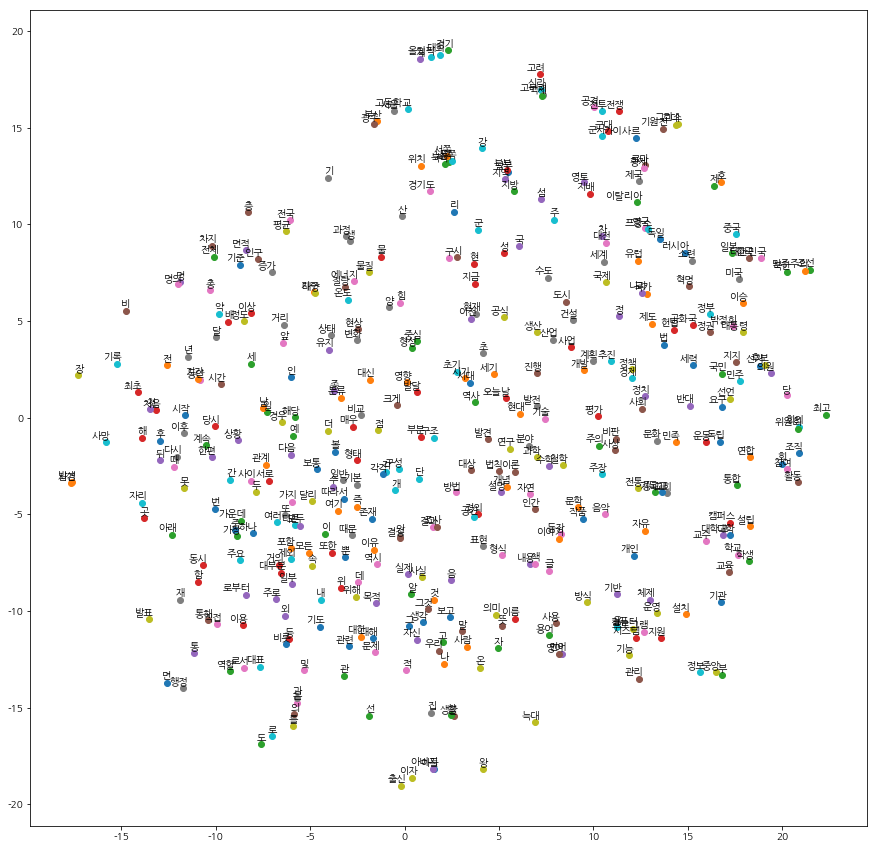

In [27]:
plt.figure(figsize=(15,15))
for i, label in enumerate(labels):
    x, y = two_d_embeddings[i,:]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
plt.show()

## Hosting / Inference (Optional)
학습을 완료하면 모델을 Amazon SageMaker 실시간 호스팅 엔드포인트(real-time hosted endpoint)로 배포할 수 있고, 이를 통해 모델로부터 추론(inference)을 수행합니다. (추론은 예측; prediction 이라고도 합니다.) 실시간 추론 수행 시 엔드포인트는 계속 가동되어야 하므로, 추론을 위해 저렴한 인스턴스를 선택하시는 것을 권장합니다.

이 과정은 약 10분 정도 소요됩니다.

In [20]:
# bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

각 단어에 대한 $n$차원 벡터($n$은 하이퍼파라메터에서 지정한 `vector_dim`)을 얻습니다. 만약 단어가 학습 데이터셋에 존재하지 않으면 모델은 0으로 구성된 벡터를 반환합니다.

In [21]:
# words = ["한국", "대한민국"]
# payload = {"instances" : words}
# response = bt_endpoint.predict(json.dumps(payload))

# vecs = json.loads(response)
# print(vecs)

## Stop / Close the Endpoint (Optional)
실시간 예측을 제공하기 위해 엔드포인트를 계속 실행할 필요가 없는 경우, 과금을 막기 위해 엔드포인트를 삭제합니다.

In [22]:
# sess.delete_endpoint(bt_endpoint.endpoint)